# Soil Organic Carbon Model

Maria Oros
JH Lab 2024

## Import ML packages

In [7]:
import scipy
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import netcdf

from sklearn import metrics
  # Import all metrics at once
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import joblib  # Optional import
import statsmodels.api as sm  # Optional import
import itertools  # Optional import
import time  # Optional import

from xgboost import XGBRegressor

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             accuracy_score)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import seaborn as sns

%matplotlib inline

In [ ]:
from sklearn.compose import ColumnTransformer

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### other libraries

In [8]:
%matplotlib inline
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [9]:
import seaborn as sns
from sklearn.metrics import r2_score

## Data input

The data input consist of ~40K soul organic carbon obrservations across the CONUS, spaning from 1985 to 2002 extracted from NEON. Each observation in time and location is obtained in 6 soil depths 5,10,15,30,100,200cm. Later 15 soil dynamic properties related to such locations and time were collected from GEE. The process of data extraction was automated using GEE API in the Cyber infraestructure that is about to be publish as part of this work.

In [10]:
data = pd.read_csv(genral_path+'final_conus_v2.csv')

### Pre procesing

Soil organic carbon observations that are valid, belong to the range 0-100

In [76]:
target='soil_organic_carbon'
soil_armonized_complete=data[data[target].between(0,100)]
soil_armonized_complete=soil_armonized_complete[~soil_armonized_complete['clay_mean'].isna()]

grouped = soil_armonized_complete.groupby(['latitude', 'longitude', 'depth_cm'])

# Select the first row of each group
data = grouped.first().reset_index()


print(data.columns)

Index(['latitude', 'longitude', 'depth_cm', 'soil_id', 'year',
       'soil_organic_carbon', 'land_use', 'land_cover', 'land_cover_class',
       'land_use_class', 'total_precipitation', 'min_temperature',
       'mean_temperature', 'max_temperature', 'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean', 'sand_mean',
       'silt_mean', 'label'],
      dtype='object')


In [77]:
data.shape

(37992, 25)

In [18]:
key_variables =['year',
                'soil_organic_carbon',
                #'depth_cm',
                'total_precipitation',
                'min_temperature',
                'mean_temperature',
                'max_temperature',
                'dem',
                'slope',
                'aspect',
                'hillshade',
                'bd_mean',
                'clay_mean',
                'om_mean',
                'ph_mean',
                'sand_mean',
                'silt_mean'
                #,'land_use', 'land_cover'
                            ]

key_variables.sort()
data[key_variables].describe()

,aspect,bd_mean,clay_mean,dem,hillshade,max_temperature,mean_temperature,min_temperature,om_mean,ph_mean,sand_mean,silt_mean,slope,soil_organic_carbon,total_precipitation,year
count,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000,37992.000000
mean,174.740901,1.378652,21.017026,508.032610,180.133791,17.972214,23.296360,5.324146,-0.135957,6.047998,31.987844,42.511539,4.369680,1.496149,1078.911728,1997.062434
std,103.047888,0.134064,11.893299,581.363783,15.858041,4.067408,7.861087,3.963573,0.541414,1.020802,22.702238,17.642474,5.799869,3.579501,552.144559,9.098066
min,0.000000,0.510000,0.500000,-2.063870,62.000000,2.382658,-8.067233,-12.104932,-4.965000,2.485503,0.838867,0.500000,0.000000,0.000020,26.470000,1985.000000
25%,86.196107,1.326348,12.354945,210.603302,177.000000,15.636130,18.429397,2.437178,-0.541625,5.216519,13.632780,29.598166,0.662710,0.255099,775.000000,1990.000000
50%,174.036351,1.388480,18.894739,301.894043,180.000000,18.868685,25.146630,6.469945,-0.107041,5.876823,25.748042,42.750610,2.049632,0.697981,1051.470000,1994.000000
75%,262.918676,1.447839,27.412397,460.408691,184.000000,20.228767,27.874795,7.553562,0.233735,6.698348,46.800392,57.094539,5.636532,1.572189,1269.910000,2004.000000
max,359.929312,1.942642,74.155243,3883.314453,255.000000,31.150219,48.934630,19.751342,1.943514,9.534649,99.500000,93.468651,46.889959,67.788097,4887.200000,2021.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37992 entries, 0 to 37991
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   latitude             37992 non-null  float64
 1   longitude            37992 non-null  float64
 2   depth_cm             37992 non-null  int64  
 3   soil_id              37992 non-null  object 
 4   year                 37992 non-null  int64  
 5   soil_organic_carbon  37992 non-null  float64
 6   land_use             37992 non-null  float64
 7   land_cover           37992 non-null  float64
 8   land_cover_class     37992 non-null  object 
 9   land_use_class       37992 non-null  object 
 10  total_precipitation  37992 non-null  float64
 11  min_temperature      37992 non-null  float64
 12  mean_temperature     37992 non-null  float64
 13  max_temperature      37992 non-null  float64
 14  dem                  37992 non-null  float64
 15  slope                37992 non-null 

In [16]:
data['land_use'] = data['land_use'].astype('category')
data['land_cover'] = data['land_cover'].astype('category')

<Axes: xlabel='year', ylabel='soil_organic_carbon'>

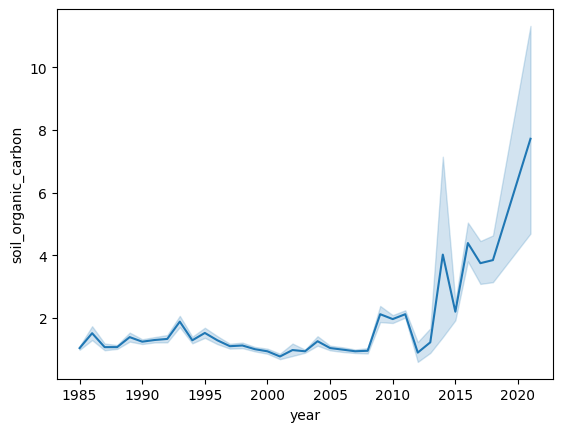

In [17]:
sns.lineplot(data=reduced_data, x="year", y="soil_organic_carbon"#, hue="version"
)

### Random Forest Regression

In [20]:
class_counts = data['soil_id'].value_counts()

# Filter classes with at least two instances
filtered_data = data[data['soil_id'].isin(class_counts[class_counts > 1].index)]
filtered_data = filtered_data[filtered_data['soil_organic_carbon'].between(0,100)]

In [21]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# Sample data

# Set the proportion for train and test (e.g., 80% train, 20% test)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)

# Split the data
train_index, test_index = next(splitter.split(data, groups=data['soil_id']))

train_data = data.iloc[train_index]
test_data = data.iloc[test_index]

# Display results
print("Train Data:",len(set(train_data['soil_id'].values)))
print("\nTest Data:", len(set(test_data['soil_id'].values)))


Train Data: 5493

Test Data: 1374


In [22]:
for x in train_data['soil_id'].values:
  if x in test_data['soil_id'].values:
    print(x)

In [23]:
for x in test_data['soil_id'].values:
  if x in train_data['soil_id'].values:
    print(x)

In [55]:
covariates=['depth_cm', 'land_use', 'land_cover',
        'total_precipitation', 'mean_temperature',#'min_temperature','max_temperature',
         'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean',
        'sand_mean'#,'silt_mean' because its correlated with sand
        ]

X_train = train_data[covariates]
Y_train = train_data['soil_organic_carbon'].values
X_test = test_data[covariates]
Y_test = test_data['soil_organic_carbon'].values


### Data visualization

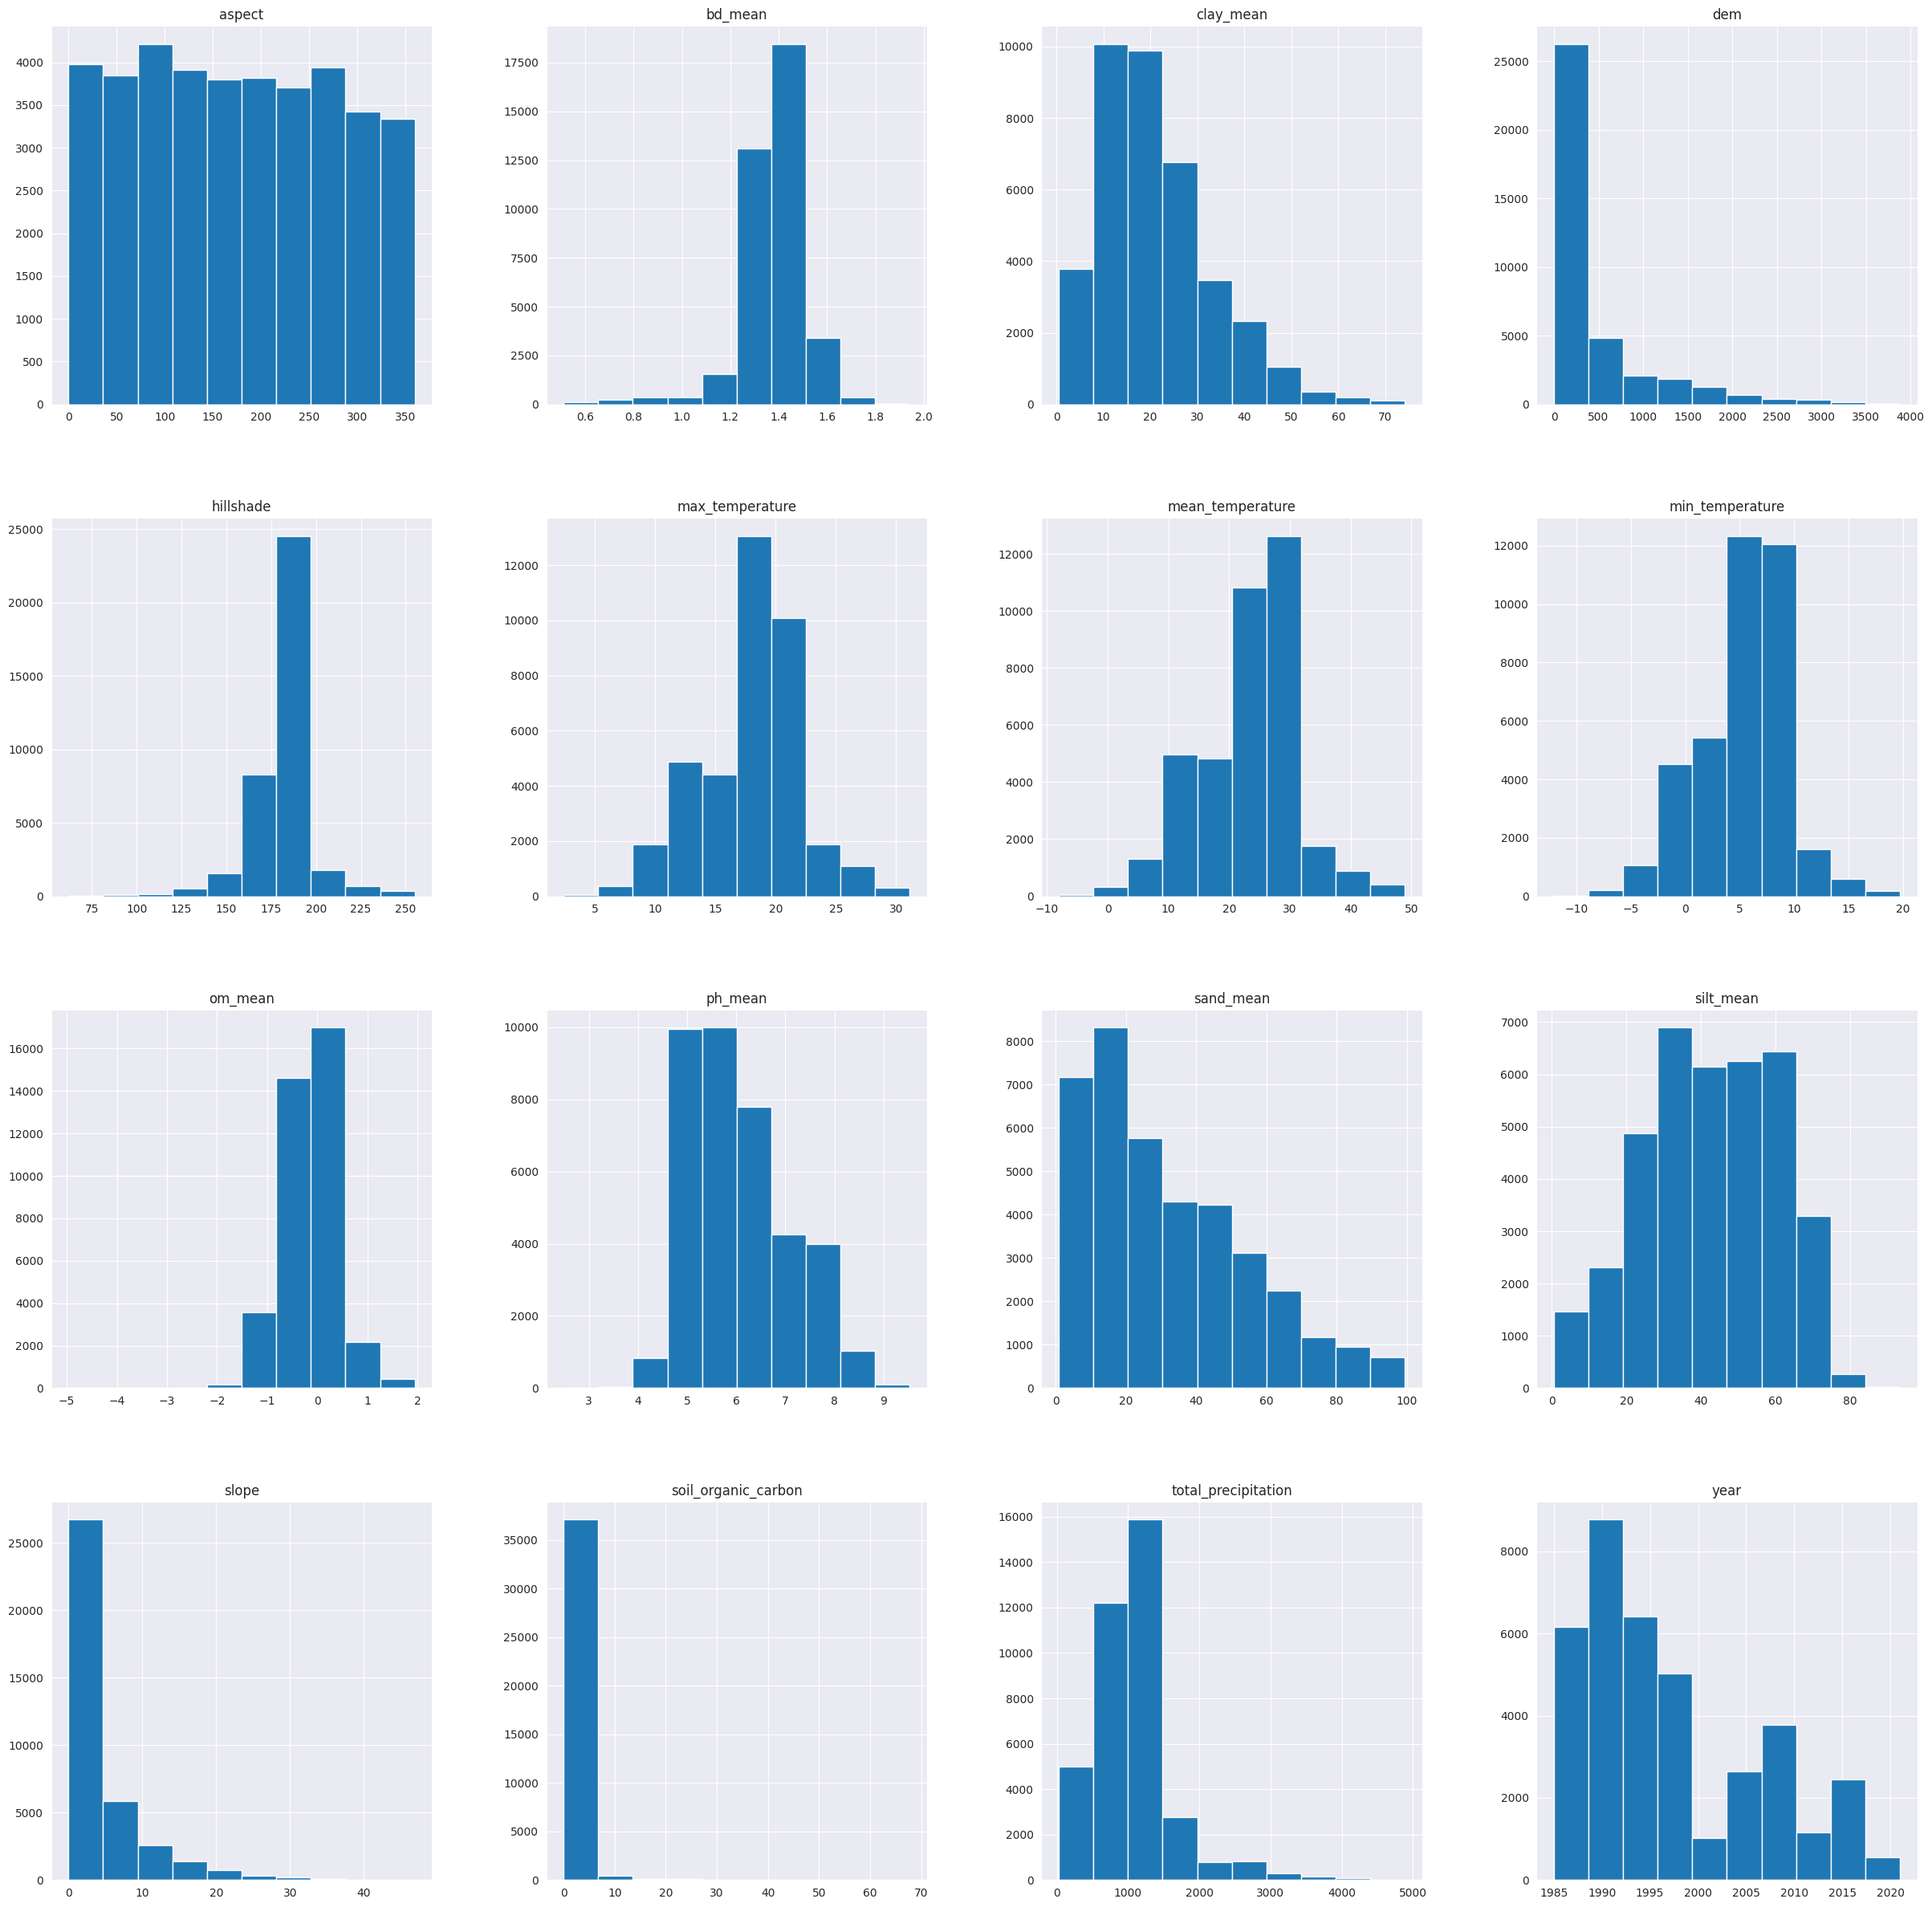

In [ ]:
# Plot histograms for each variable
sns.set_style('darkgrid')
filtered_data[key_variables].hist(figsize=(30,30))
plt.show()

In [25]:
filtered_data[key_variables].describe()

,aspect,bd_mean,clay_mean,dem,hillshade,max_temperature,mean_temperature,min_temperature,om_mean,ph_mean,sand_mean,silt_mean,slope,soil_organic_carbon,total_precipitation,year
count,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000,37972.000000
mean,174.730416,1.378651,21.018801,507.771393,180.132782,17.972564,23.297314,5.324750,-0.135958,6.047724,31.981373,42.518036,4.368068,1.494076,1079.018150,1997.064205
std,103.050586,0.134047,11.892544,581.147646,15.850632,4.067472,7.861233,3.963565,0.541300,1.020577,22.701033,17.640260,5.798247,3.571980,552.159502,9.098412
min,0.000000,0.510000,0.500000,-2.063870,62.000000,2.382658,-8.067233,-12.104932,-4.965000,2.485503,0.838867,0.500000,0.000000,0.000020,26.470000,1985.000000
25%,86.196107,1.326348,12.357837,210.573990,177.000000,15.636130,18.429781,2.437178,-0.541575,5.216472,13.630648,29.606030,0.662375,0.255099,775.140000,1990.000000
50%,174.012240,1.388478,18.899022,301.859436,180.000000,18.868740,25.146630,6.471342,-0.106945,5.876685,25.741095,42.757812,2.049380,0.698054,1051.470000,1994.000000
75%,262.918676,1.447791,27.415954,460.169006,184.000000,20.228767,27.874904,7.553562,0.233717,6.697277,46.800392,57.104942,5.635239,1.571914,1269.910000,2004.000000
max,359.929312,1.942642,74.155243,3883.314453,255.000000,31.150219,48.934630,19.751342,1.943514,9.534649,99.500000,93.468651,46.889959,67.788097,4887.200000,2021.000000


From the matrix of correlations we observe that Organic matter is the more correlated variable with soil organic carbon, followed by bulk density. Correlation between other variables as min temperature and max temperature could affect the model performance because of a multicolinearity issue, so for such reason, some variables were removed frm the modeling side in the modelling steps.

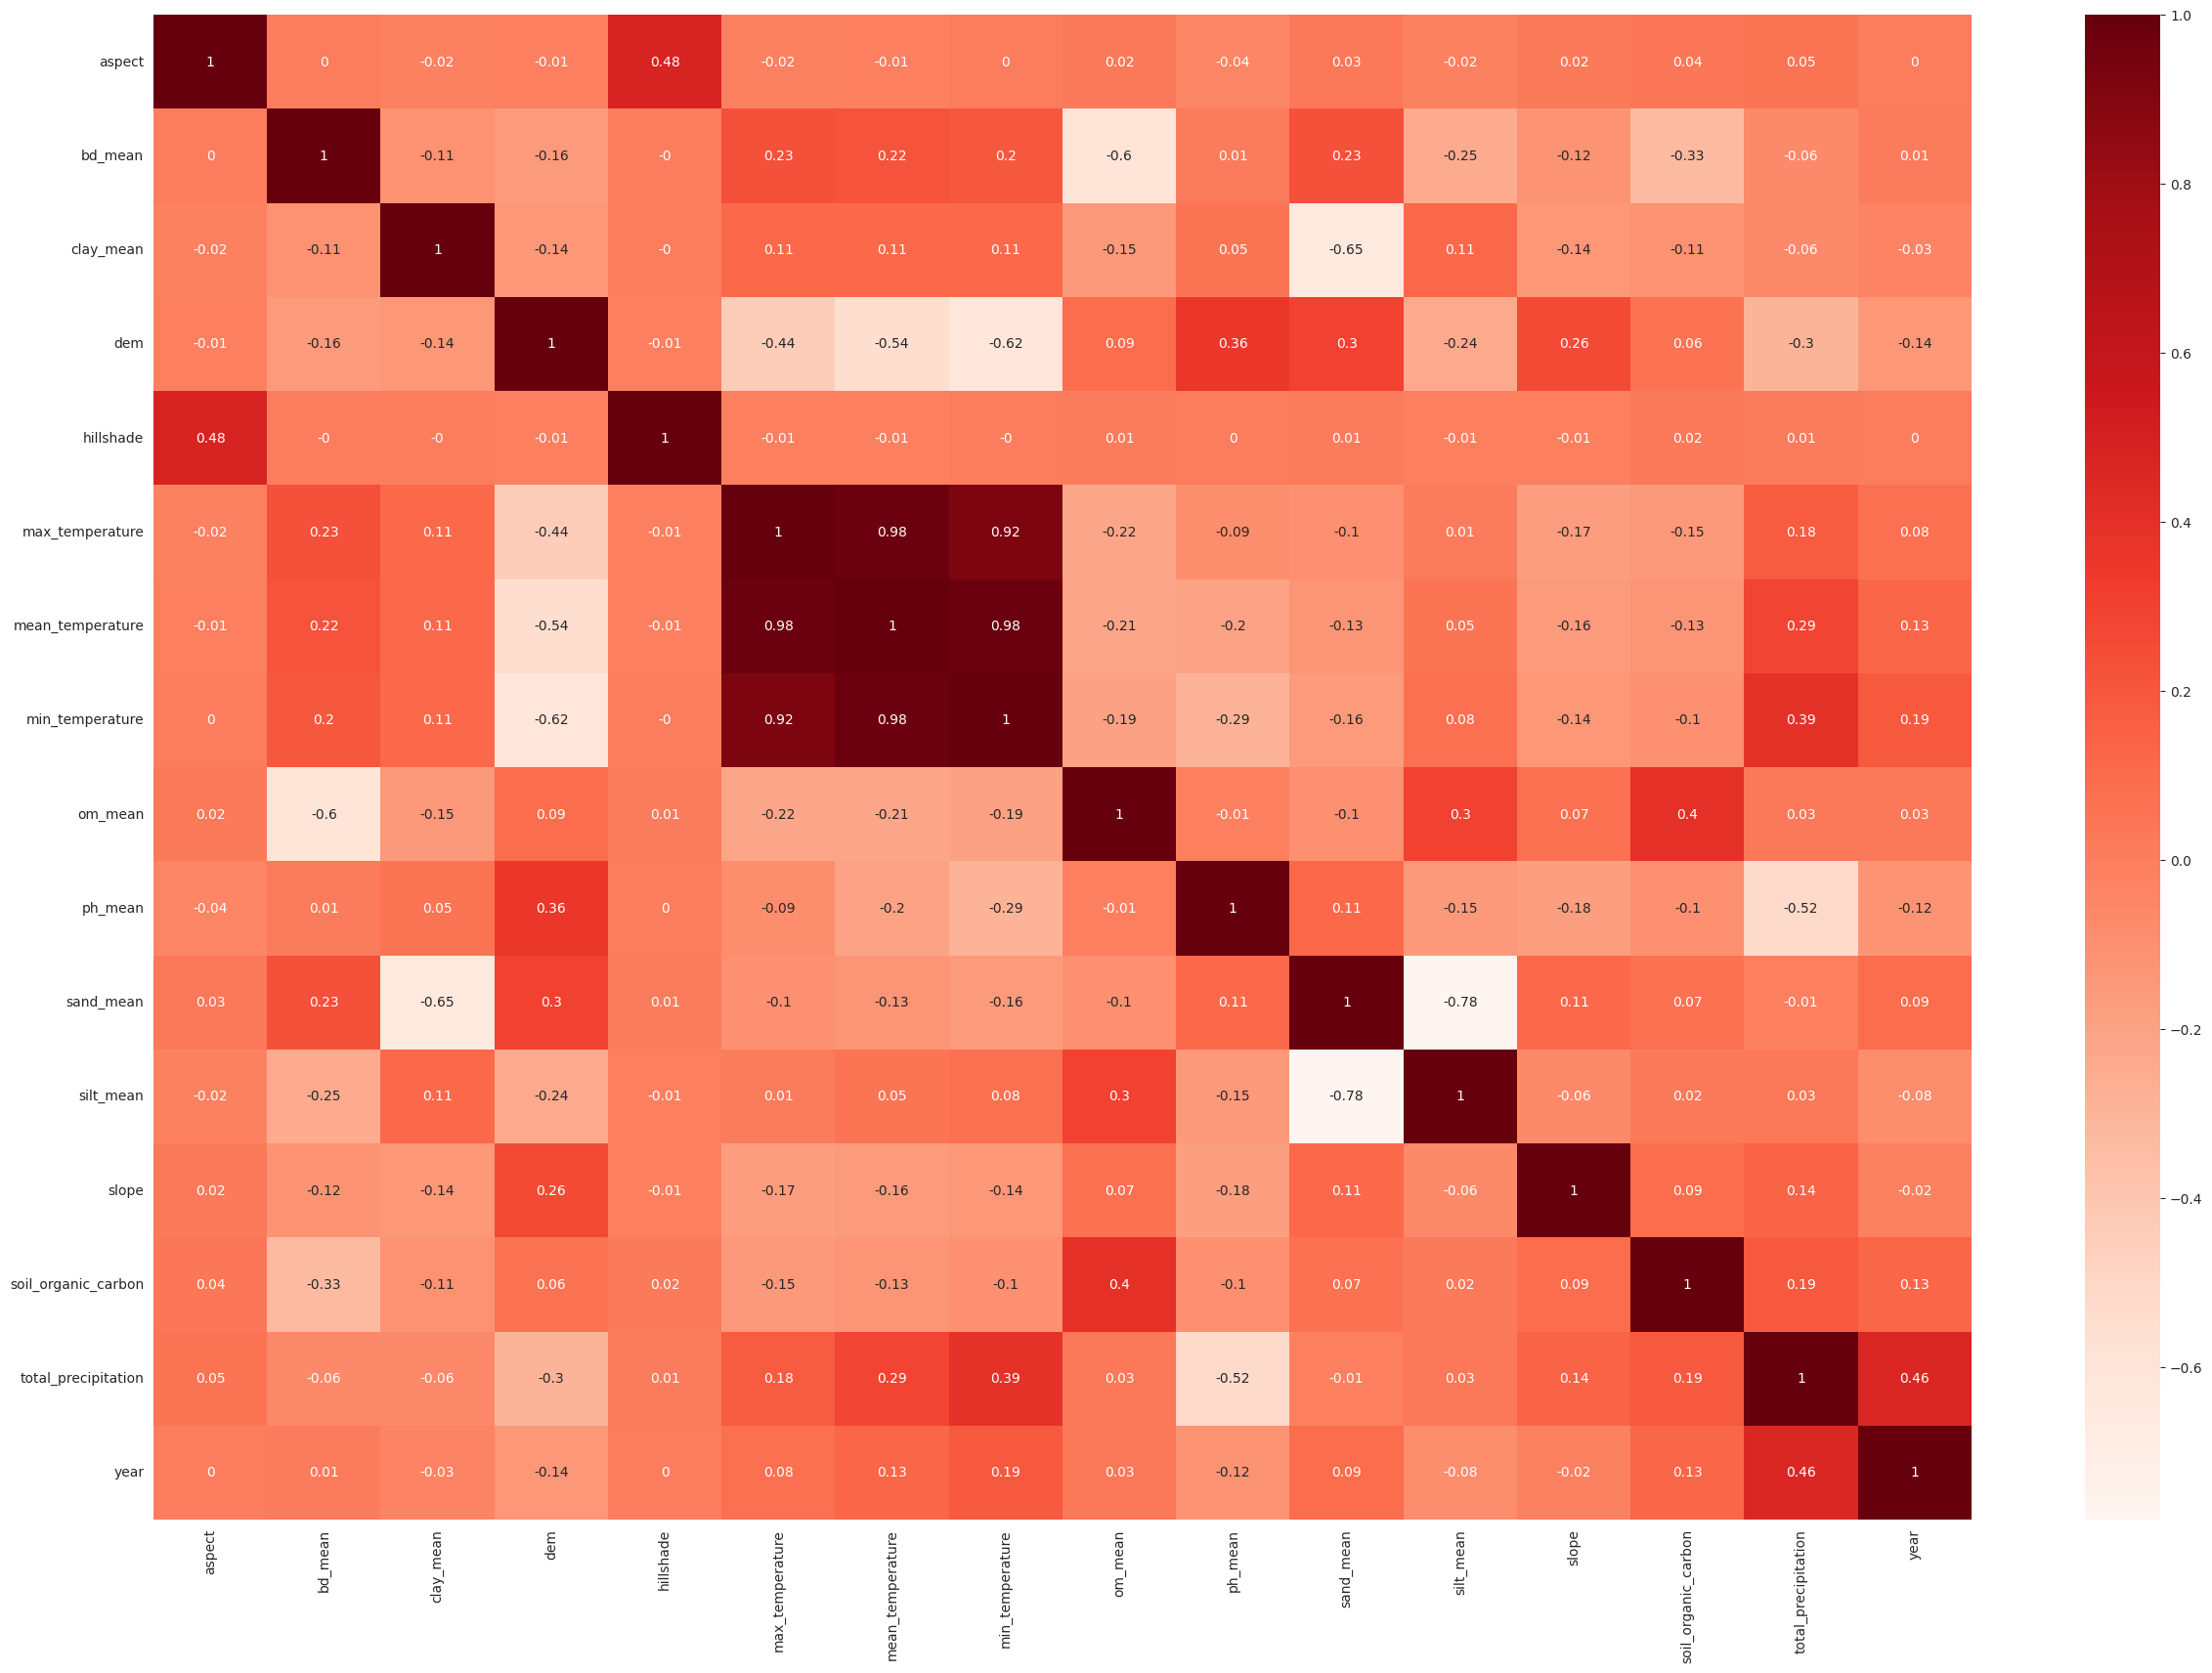

In [ ]:
plt.figure(figsize=(30,20))
cor = filtered_data[key_variables].corr().round(2)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [27]:
#Correlation with output variable, bulk density and organic matter the more correlated with soil organic carbon.
cor_target = abs(cor["soil_organic_carbon"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features

,soil_organic_carbon
bd_mean,0.33
om_mean,0.40
soil_organic_carbon,1.00


## Modeling Soil Organic Carbon

In [28]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

#### Comparing models on predicting SOC

In [29]:
# Define models to train
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Random Forest', RandomForestRegressor()))
#models.append(('SVR', SVR()))
#models.append(('XGBoost', xgb.XGBRegressor()))

In [30]:
import time
start_time = time.time()


# Define scoring metrics for regression
scoring = 'r2'

# Evaluate each model in turn
results = []
names = []

for name, model in models:
  kfold = KFold(n_splits=10, shuffle=True, random_state=1)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)

  names.append(name)
  msg = "For %s Model: R2 is %f (Std R2 is %f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

#above should be positive eg instead of -cv_results.mean() is cv_results.mean()
print("--- %s seconds ---" % (time.time() - start_time))

For Linear Regression Model: R2 is 0.234771 (Std R2 is 0.017010)
For Random Forest Model: R2 is 0.520810 (Std R2 is 0.047875)
--- 747.4227750301361 seconds ---


In [32]:
import pandas as pd
from xgboost import XGBRegressor

covariates=['depth_cm', 'land_use', 'land_cover',
        'total_precipitation', #'min_temperature','max_temperature',
       'mean_temperature',  'dem', 'slope', 'aspect',
       'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean',
        'sand_mean'#,'silt_mean' because its correlated with 3
        ]

# One-hot encoding
X_train_xgb = pd.get_dummies(X_train, columns=['land_use', 'land_cover'])


model = XGBRegressor(enable_categorical=True)
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(model, X_train_xgb, Y_train, cv=kfold, scoring=scoring)
results.append(cv_results)

#names.append(name)
msg = "For %s Model: Mean r2 is %f (Std r2 is %f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

names.append('XGBoostModel')

For Random Forest Model: Mean r2 is 0.592148 (Std r2 is 0.059563)


In [46]:
model = XGBRegressor(enable_categorical=True)
xgboost = model.fit(X_train_xgb, Y_train)

In [84]:
X_train_xgb.columns

Index(['depth_cm', 'total_precipitation', 'mean_temperature', 'dem', 'slope',
       'aspect', 'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean',
       'sand_mean', 'land_use_1.0', 'land_use_2.0', 'land_use_3.0',
       'land_use_4.0', 'land_use_5.0', 'land_use_6.0', 'land_cover_1.0',
       'land_cover_3.0', 'land_cover_4.0', 'land_cover_7.0', 'land_cover_8.0',
       'land_cover_9.0', 'land_cover_10.0', 'land_cover_12.0',
       'land_cover_14.0'],
      dtype='object')

In [82]:
prediction = xgboost.predict(X_train_xgb)

### Choosing XGBoost model by parameter optimization

In [34]:
import time
start_time = time.time()

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the model and parameters
xgb1 = XGBRegressor(enable_categorical=True)
parameters = {
    'objective': ['reg:squarederror'],
    'learning_rate': [0.0001, 0.001, 0.01],
    'max_depth': [3, 5, 7],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.1, 0.5, 1.0],
    'n_estimators': [500]
}

# Set up GridSearchCV
xgb_grid = GridSearchCV(
    estimator=xgb1,
    param_grid=parameters,
    cv=3,
    n_jobs=-1,
    verbose=0
)

# Fit the model with grid search
xgb_grid.fit(X_train, Y_train)

# Print the best score and parameters
print("Best Score:", xgb_grid.best_score_)
print("Best Parameters:", xgb_grid.best_params_)


#above should be positive eg instead of -cv_results.mean() is cv_results.mean()
print("--- %s seconds ---" % (time.time() - start_time))

Best Score: 0.2838540126286718
Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.1}
--- 1139.4538464546204 seconds ---


In [38]:
best_model = xgb_grid.best_estimator_

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(best_model, X_train, Y_train, cv=kfold, scoring='r2')

#names.append(name)
msg = "For %s Model: Mean r2 is %f (Std r2 is %f)" % ('XG Boost Best', cv_results.mean(), cv_results.std())
print(msg)

results.append(cv_results)
names.append('XGBoost_best')

For XG Boost Best Model: Mean r2 is 0.387291 (Std r2 is 0.026732)


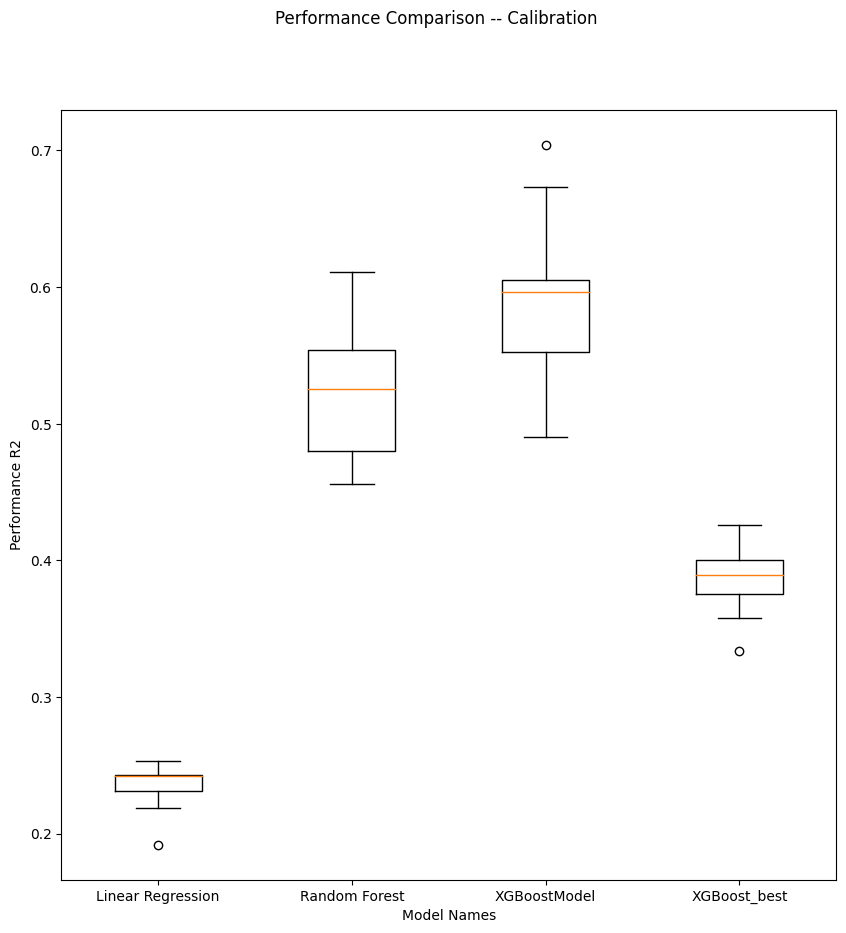

In [36]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Performance Comparison -- Calibration')
ax = fig.add_subplot(111)
plt.boxplot(results)
# Adding x-axis and y-axis labels
ax.set_xlabel('Model Names')  # Replace with your desired x-axis label
ax.set_ylabel('Performance R2')  # Replace with your desired y-axis label

ax.set_xticklabels(names)
plt.show()

### Test set

In [66]:
trans = StandardScaler()
train_data_ss = trans.fit_transform(train_data[covariates])
test_data_ss = trans.fit_transform(test_data[covariates])

In [67]:
#X_train = train_data[covariates]
Y_train = train_data['soil_organic_carbon'].values
#X_test = test_data[covariates]
Y_test = test_data['soil_organic_carbon'].values


In [68]:
import time
start_time = time.time()


# Define scoring metrics for regression
scoring = 'r2'

# Evaluate each model in turn
results_test = []
names_test = []

for name, model in models:
  kfold = KFold(n_splits=10, shuffle=True, random_state=1)
  cv_results = cross_val_score(model, test_data_ss, Y_test, cv=kfold, scoring=scoring)
  results_test.append(cv_results)

  names_test.append(name)
  msg = "For %s Model: R2 is %f (Std R2 is %f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

#above should be positive eg instead of -cv_results.mean() is cv_results.mean()
print("--- %s seconds ---" % (time.time() - start_time))

For Linear Regression Model: R2 is 0.216300 (Std R2 is 0.052096)
For Random Forest Model: R2 is 0.459026 (Std R2 is 0.147265)
For SVR Model: R2 is 0.230931 (Std R2 is 0.064787)
--- 177.79384183883667 seconds ---


In [72]:
# One-hot encoding
test_data_ss_xgb = test_data_ss
#pd.get_dummies(test_data_ss, columns=['land_use', 'land_cover'])

model = XGBRegressor(enable_categorical=True)
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(model, test_data_ss_xgb, Y_test, cv=kfold, scoring=scoring)
results_test.append(cv_results)
names_test.append("XGBoost")

In [73]:
best_model = xgb_grid.best_estimator_

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(best_model, test_data_ss, Y_test, cv=kfold, scoring='r2')

#names.append(name)
msg = "For XGBOOST best Model: Mean r2 is %f (Std r2 is %f)" % ( cv_results.mean(), cv_results.std())
print(msg)

results_test.append(cv_results)
names_test.append("XGBoost_best")

For XGBOOST best Model: Mean r2 is 0.353356 (Std r2 is 0.062730)


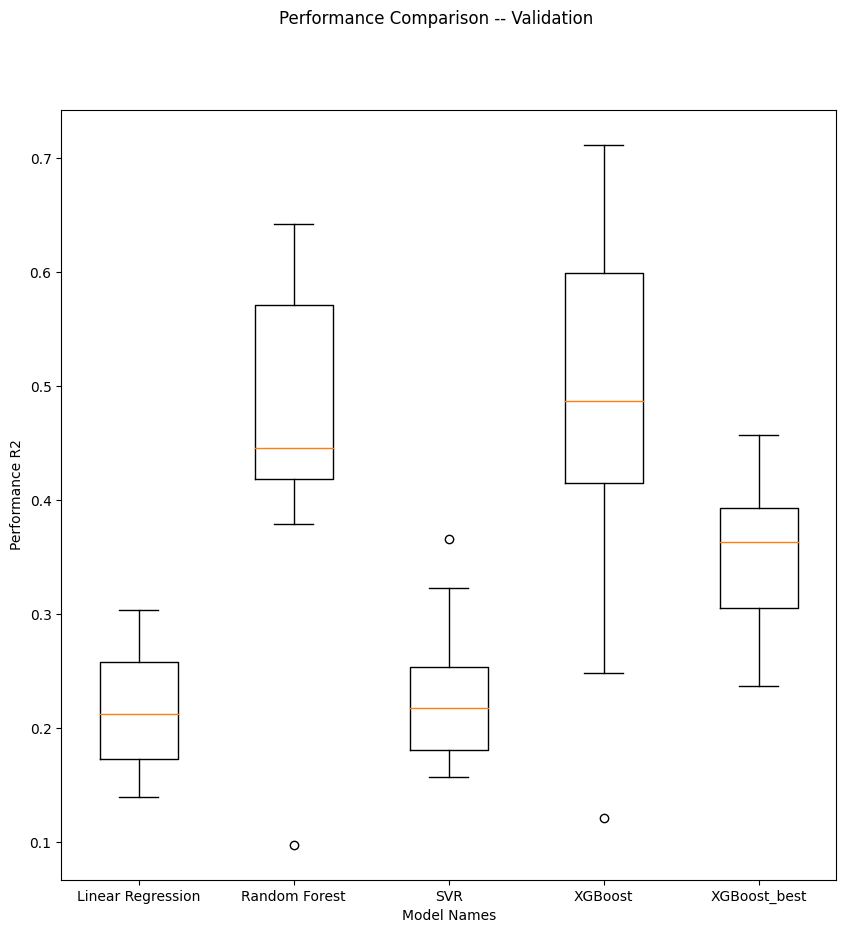

In [74]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Performance Comparison -- Validation')
ax = fig.add_subplot(111)
plt.boxplot(results_test)
# Adding x-axis and y-axis labels
ax.set_xlabel('Model Names')  # Replace with your desired x-axis label
ax.set_ylabel('Performance R2')  # Replace with your desired y-axis label

ax.set_xticklabels(names_test)
plt.show()

## Saving the model

In [102]:
best_model = xgboost
joblib.dump(best_model, 'xgb_model.joblib')


best_model.save_model('xgb_model.json')

### Evaluating standarized data

In [53]:
# Standardize the dataset
import warnings
pipelines = []

pipelines.append(('Scaled Linear Regression', Pipeline([('Scaler', StandardScaler()),('Linear Regression', LinearRegression())])))
pipelines.append(('Scaled Random Forest', Pipeline([('Scaler', StandardScaler()),('Random Forest', RandomForestRegressor())])))

results = []
names = []

kfold = KFold(n_splits= 10)
for name, model in pipelines:
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='r2')
  results.append(cv_results)
  names.append(name)
  print( "For %s Model: Mean R2 is %f (Std Accuracy is %f)" % (name, cv_results.mean(), cv_results.std()))

For Scaled Linear Regression Model: Mean Accuracy is 0.220308 (Std Accuracy is 0.027242)
For Scaled Random Forest Model: Mean Accuracy is 0.135957 (Std Accuracy is 0.364704)


In [56]:
X_train_xgb = pd.get_dummies(X_train, columns=['land_use', 'land_cover'])
X_test_xgb = pd.get_dummies(X_test, columns=['land_use', 'land_cover'])


In [57]:
# List of columns to scale (all columns are numerical after pd.get_dummies)
columns_to_scale = X_train_xgb.columns

# Define preprocessor with StandardScaler for all columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale)
    ]
)

# Create a pipeline with preprocessing and the XGBRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
])

# Set up cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

# Evaluate the pipeline using cross-validation
cv_results = cross_val_score(pipeline, X_train_xgb, Y_train, cv=kfold, scoring='r2')

name = "XGBoost"
names.append(name)
results.append(cv_results)

# Print cross-validation results
print(cv_results)


[0.70417999 0.56684754 0.5478912  0.48072886 0.56376702 0.59628864
 0.60405607 0.59273047 0.53156424 0.66952833]


In [93]:
columns_to_scale = X_train_xgb.columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale)
    ]
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
])

# Fit the pipeline
pipeline.fit(X_train_xgb, Y_train)

# Make predictions
y_pred = pipeline.predict(X_train_xgb)

### Saving models

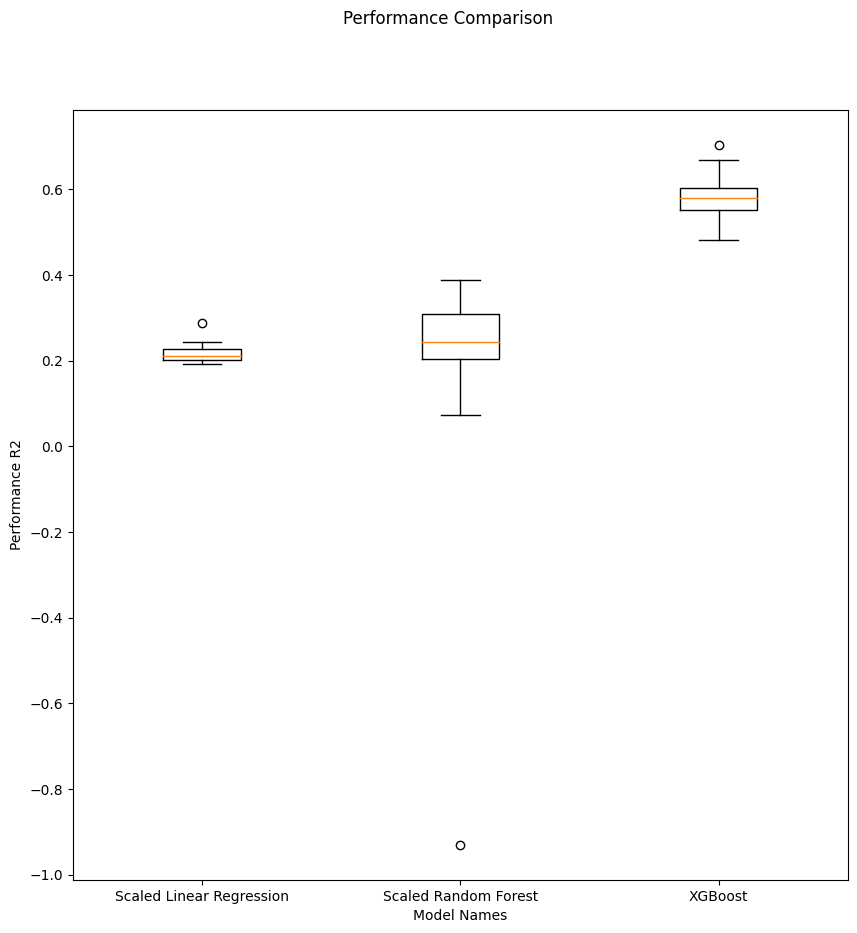

In [63]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

ax.set_xlabel('Model Names')  # Replace with your desired x-axis label
ax.set_ylabel('Performance R2')  # Replace with your desired y-axis label

plt.show()

In [100]:
import joblib
from sklearn.preprocessing import StandardScaler

# Create and fit the scaler
scaler = StandardScaler()
scaler.fit(X_train_xgb)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
best_model = xgboost
joblib.dump(best_model, 'best_xgb_model.joblib')


best_model.save_model('xgb_model.json')

In [96]:
import xgboost as xgb


In [97]:
model = xgb.XGBRegressor()
model.load_model('xgb_model.json')

In [ ]:
data_input = transform_to_dataframe([request])
data_to_predict = scaler.transform(data_input)

#### Now evaluation on the test data

In [85]:
# Standardize the dataset
import warnings
pipelines = []

pipelines.append(('Scaled Linear Regression', Pipeline([('Scaler', StandardScaler()),('Linear Regression', LinearRegression())])))
pipelines.append(('Scaled Random Forest', Pipeline([('Scaler', StandardScaler()),('Random Forest', RandomForestRegressor())])))

results_ss = []
names_ss = []

kfold = KFold(n_splits= 10)
for name, model in pipelines:
  cv_results = cross_val_score(model, X_test, Y_test, cv=kfold, scoring='r2')
  results_ss.append(cv_results)
  names_ss.append(name)
  print( "For %s Model: Mean R2 is %f (Std Accuracy is %f)" % (name, cv_results.mean(), cv_results.std()))

For Scaled Linear Regression Model: Mean R2 is 0.056283 (Std Accuracy is 0.297247)
For Scaled Random Forest Model: Mean R2 is -0.247180 (Std Accuracy is 1.054705)


In [89]:
columns_to_scale

Index(['depth_cm', 'total_precipitation', 'mean_temperature', 'dem', 'slope',
       'aspect', 'hillshade', 'bd_mean', 'clay_mean', 'om_mean', 'ph_mean',
       'sand_mean', 'land_use_1.0', 'land_use_2.0', 'land_use_3.0',
       'land_use_4.0', 'land_use_5.0', 'land_use_6.0', 'land_cover_1.0',
       'land_cover_3.0', 'land_cover_4.0', 'land_cover_7.0', 'land_cover_8.0',
       'land_cover_9.0', 'land_cover_10.0', 'land_cover_12.0',
       'land_cover_14.0'],
      dtype='object')

In [86]:
# List of columns to scale (all columns are numerical after pd.get_dummies)
columns_to_scale = X_test_xgb.columns

# Define preprocessor with StandardScaler for all columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale)
    ]
)

# Create a pipeline with preprocessing and the XGBRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
])

# Set up cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

# Evaluate the pipeline using cross-validation
cv_results = cross_val_score(pipeline, X_test_xgb, Y_test, cv=kfold, scoring='r2')

name = "Scaler XGBoost"
names_ss.append(name)
results_ss.append(cv_results)


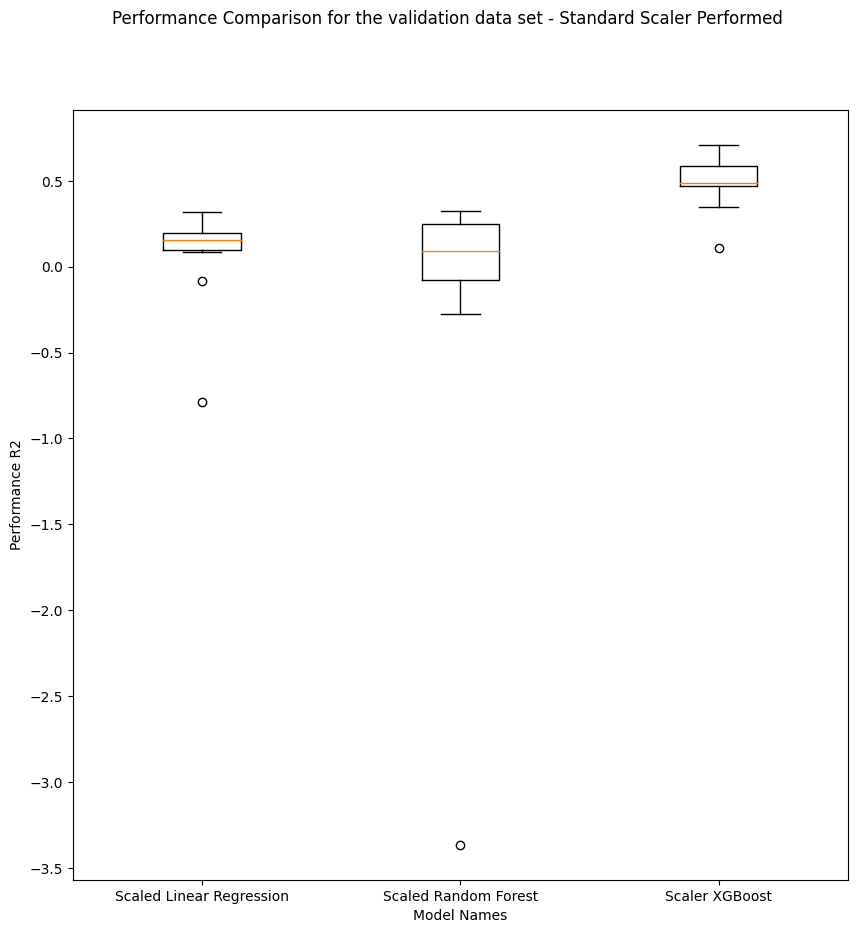

In [88]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Performance Comparison for the validation data set - Standard Scaler Performed')
ax = fig.add_subplot(111)
plt.boxplot(results_ss)
ax.set_xticklabels(names_ss)

ax.set_xlabel('Model Names')  # Replace with your desired x-axis label
ax.set_ylabel('Performance R2')  # Replace with your desired y-axis label

plt.show()

CONCLUSION: Not to much difference between the models once the standard scaler is performed

### Validation dataset

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Define models
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor()),
    ('SVR', SVR())
    # ('XGBoost', XGBRegressor(enable_categorical=True)) # Uncomment if you want to use XGBoost
]


# Iterate over models and evaluate
for name, model in models:
    try:
        # Apply scaling
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the model
        model.fit(X_train_scaled, Y_train)

        # Make predictions
        predictions = model.predict(X_test_scaled)

        # Print the results
        print("\nModel:", name)
        print("Mean Squared Error:", mean_squared_error(Y_test, predictions))
        print("R-squared:", r2_score(Y_test, predictions))

        predictions_cali = model.predict(X_train_scaled)
        print("R-squared calibration:", r2_score(Y_train, predictions_cali))

    except Exception as e:
        print("Exception encountered with model", name, ":", e)



Model: Linear Regression
Mean Squared Error: 11.008464777365857
R-squared: 0.21379433213734844
R-squared calibration: 0.23719446024703028

Model: Random Forest
Mean Squared Error: 8.92458625061338
R-squared: 0.3626213613375182
R-squared calibration: 0.9338704964427884

Model: SVR
Mean Squared Error: 10.912987407111762
R-squared: 0.2206131621163232
R-squared calibration: 0.2553682929341453
